### Read network data

In [100]:
import pickle
import networkx as nx
import numpy as np

with open(r"D:\Master\Thesis\Code\traffic\metr-la\adj_METR-LA.pkl", 'rb') as f:
    spatial = pickle.load(f, encoding='latin1')

sensor_id = spatial[0]
sensor_nodes = spatial[1]
adj = spatial[2]

# Build NetworkX graph
G = nx.from_numpy_array(adj, create_using=nx.DiGraph())
nx.set_node_attributes(G, {v: k for k, v in sensor_nodes.items()}, name="sensor_id")

In [151]:
adj

array([[1.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 0.3909554, ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.7174379, 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        1.       ]], dtype=float32)

In [124]:
print(np.min(adj), np.max(adj), np.mean(adj))


0.0 1.0 0.019010518


### Read semantic data

In [102]:
# Find the key with value 181
key_for_181 = next((k for k, v in sensor_nodes.items() if v == 182), None)
print(key_for_181)

717825


In [103]:
from rdflib import Graph, Namespace
import numpy as np
import pandas as pd

g = Graph()
g.parse("LA_traffic_KG.ttl", format="ttl")

TRAFFIC = Namespace("http://example.org/traffic#")

# Get semantic features per sensor
query = """
PREFIX traffic: <http://example.org/traffic#>
SELECT ?sensor ?roadType ?maxSpeed ?numLanes
WHERE {
  ?sensor a traffic:TrafficSensor ;
          traffic:installedOn ?road .
  ?road traffic:roadType ?roadType ;
        traffic:maxSpeed ?maxSpeed ;
        traffic:numberOfLanes ?numLanes .
}
"""

results = g.query(query)
rows = []
for r in results:
    sensor_uri = str(r.sensor)
    sensor_id = sensor_uri.split("#")[-1].replace("sensor_", "")
    rows.append({
        "sensor_id": sensor_id,
        "road_type": str(r.roadType),
        "max_speed": float(r.maxSpeed),
        "num_lanes": int(r.numLanes)
    })

sensor_ids = [row["sensor_id"] for row in rows]

semantic_df = pd.DataFrame(rows)

In [104]:
semantic_df

,sensor_id,road_type,max_speed,num_lanes
0,773869,motorway,65.0,5
1,767541,motorway,65.0,4
2,767542,motorway,65.0,4
3,717447,motorway,55.0,4
4,717446,motorway,55.0,4
...,...,...,...,...
175,717592,motorway,65.0,5
176,717595,motorway,65.0,5
177,772168,motorway,65.0,6
178,718141,motorway,55.0,3


In [147]:
sensor_ids = semantic_df["sensor_id"].astype(str).tolist()

### Select only distances for sensors with semantics available

In [105]:
graph_nodes = list(G.nodes())  # This will give a list of all node indices in the graph

In [106]:
node_to_sensor = {node: sensor_id for sensor_id, node in sensor_nodes.items()}
node_to_sensor

{110: '717099',
 0: '773869',
 1: '767541',
 2: '767542',
 3: '717447',
 4: '717446',
 5: '717445',
 6: '773062',
 84: '767053',
 8: '737529',
 9: '717816',
 10: '765604',
 11: '767471',
 12: '716339',
 86: '772596',
 14: '765273',
 15: '716331',
 16: '771667',
 17: '716337',
 18: '769953',
 19: '769402',
 20: '769403',
 21: '769819',
 22: '769405',
 164: '769345',
 25: '716960',
 26: '717804',
 27: '767572',
 28: '767573',
 29: '773012',
 30: '773013',
 31: '764424',
 176: '764101',
 32: '769388',
 33: '716328',
 34: '717819',
 35: '769941',
 36: '760987',
 37: '718204',
 38: '718045',
 39: '769418',
 40: '768066',
 41: '772140',
 42: '773927',
 126: '769867',
 138: '772513',
 44: '774012',
 45: '774011',
 46: '767609',
 48: '760650',
 131: '765099',
 50: '769831',
 166: '772669',
 92: '767585',
 53: '716554',
 54: '773953',
 55: '767470',
 132: '762329',
 57: '764949',
 58: '773954',
 59: '767366',
 60: '769444',
 61: '773939',
 62: '774067',
 63: '769443',
 64: '767750',
 65: '76775

In [107]:
common_sensors = []

for node, sensor in node_to_sensor.items():
    if sensor in semantic_df["sensor_id"].values:
        common_sensors.append(sensor)

In [108]:
len(common_sensors)

180

In [109]:
common_sensors in semantic_df["sensor_id"].values

True

In [110]:
# Create a subgraph with only the nodes whose corresponding sensor_id is in common_sensors
common_sensor_nodes = [node for node, sensor in node_to_sensor.items() if sensor in common_sensors]

# Create the subgraph from the original graph G
G = G.subgraph(common_sensor_nodes).copy()

### Attach semantic features to nodes

In [111]:
for idx, row in semantic_df.iterrows():
    node = sensor_nodes.get(row["sensor_id"])
    if node is not None:
        for col in semantic_df.columns:
            if col != "sensor_id":
                G.nodes[node][col] = row[col]


In [112]:
# Remove all self-loops (edges from a node to itself)
self_loops = list(nx.selfloop_edges(G))
G.remove_edges_from(self_loops)

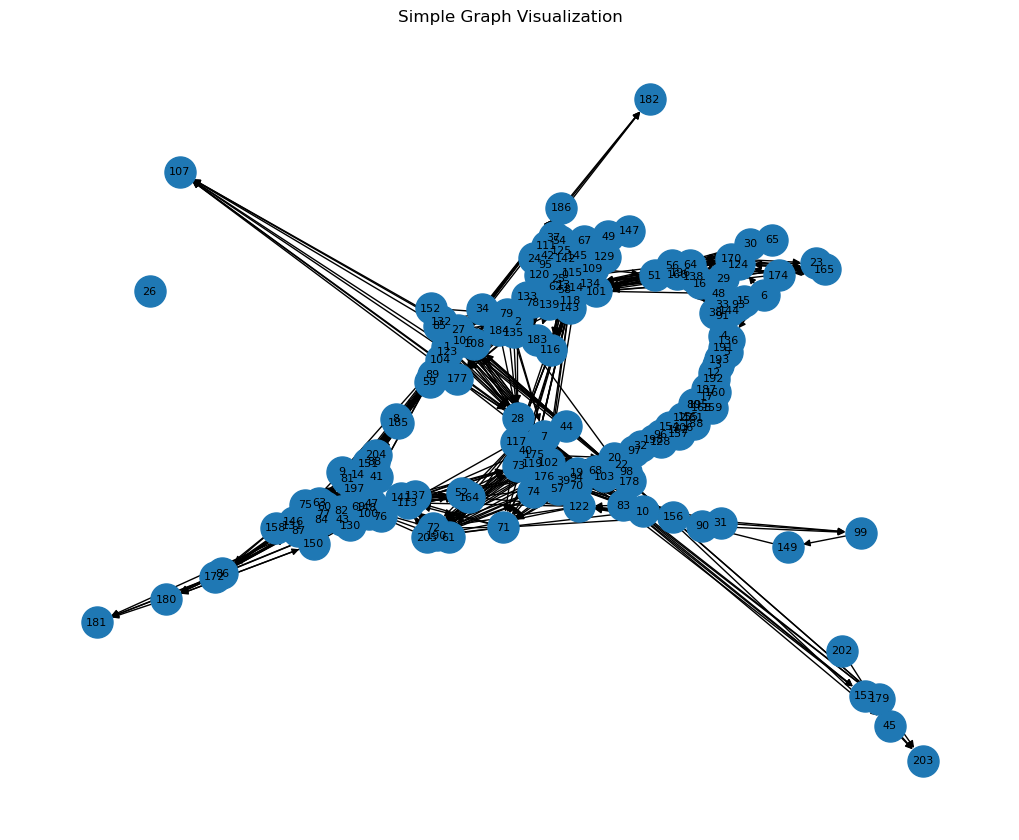

In [113]:
import networkx as nx
import matplotlib.pyplot as plt

# Assume G is your graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # You can also try nx.kamada_kawai_layout(G) for better spacing

# Draw the graph with labels
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, arrows=True)

plt.title("Simple Graph Visualization")
plt.axis('off')
plt.show()


### Normalize semantic features

In [115]:
from sklearn.preprocessing import StandardScaler

# Assume semantic_df has columns: sensor_id, max_speed, num_lanes, road_type
semantic_encoded = pd.get_dummies(semantic_df, columns=["road_type"]).astype(int)

X = semantic_encoded[["max_speed", "num_lanes"]]
X_scaled = StandardScaler().fit_transform(X)
semantic_encoded[["max_speed", "num_lanes"]] = X_scaled

In [116]:
semantic_encoded

,sensor_id,max_speed,num_lanes,road_type_bridleway,road_type_cycleway,road_type_motorway,road_type_motorway_link,road_type_path,road_type_primary,road_type_residential
0,773869,0.499567,0.535477,0,0,1,0,0,0,0
1,767541,0.499567,-0.189229,0,0,1,0,0,0,0
2,767542,0.499567,-0.189229,0,0,1,0,0,0,0
3,717447,-0.111317,-0.189229,0,0,1,0,0,0,0
4,717446,-0.111317,-0.189229,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
175,717592,0.499567,0.535477,0,0,1,0,0,0,0
176,717595,0.499567,0.535477,0,0,1,0,0,0,0
177,772168,0.499567,1.260182,0,0,1,0,0,0,0
178,718141,-0.111317,-0.913934,0,0,1,0,0,0,0


In [137]:
# Feature semantic distance
from scipy.spatial.distance import pdist, squareform

features = semantic_encoded.drop(columns=["sensor_id"]).values
semantic_features_matrix = squareform(pdist(features, metric="euclidean"))
semantic_features_matrix

array([[0.        , 0.72470557, 0.72470557, ..., 0.72470557, 1.5728862 ,
        0.94782725],
       [0.72470557, 0.        , 0.        , ..., 1.44941114, 0.94782725,
        0.61088324],
       [0.72470557, 0.        , 0.        , ..., 1.44941114, 0.94782725,
        0.61088324],
       ...,
       [0.72470557, 1.44941114, 1.44941114, ..., 0.        , 2.25830951,
        1.5728862 ],
       [1.5728862 , 0.94782725, 0.94782725, ..., 2.25830951, 0.        ,
        0.72470557],
       [0.94782725, 0.61088324, 0.61088324, ..., 1.5728862 , 0.72470557,
        0.        ]])

### Combine semantic and spatial features

In [138]:
import numpy as np
import scipy.sparse as sp

# Step 1: Create reverse mapping from sensor_id → node index
sensor_to_node = {v: k for k, v in node_to_sensor.items()}

# Step 2: Create index list for reordering
# These are the node indices in the order of common_sensors
ordered_sensor_ids = semantic_df["sensor_id"].values
node_indices = [sensor_to_node[sensor_id] for sensor_id in ordered_sensor_ids if sensor_id in sensor_to_node]

# Step 3: Reorder the adjacency matrix
# Assuming `adj_matrix` is a scipy.sparse matrix (180x180)
adj_matrix_reordered = adj[node_indices, :][:, node_indices]

In [139]:
len(node_indices)

180

In [140]:
print(np.min(adj_matrix_reordered), np.max(adj_matrix_reordered), np.mean(adj_matrix_reordered))


0.0 1.0 0.022087533


In [141]:
alpha = 0.5  # balance between semantic and physical (distance-based)
combined_matrix = alpha * semantic_features_matrix + (1 - alpha) * adj_matrix_reordered

In [142]:
combined_matrix

array([[0.5       , 0.36235279, 0.36235279, ..., 0.36235279, 0.7864431 ,
        0.47391363],
       [0.36235279, 0.5       , 0.19547769, ..., 0.72470557, 0.47391363,
        0.30544162],
       [0.36235279, 0.35871896, 0.5       , ..., 0.72470557, 0.47391363,
        0.30544162],
       ...,
       [0.36235279, 0.72470557, 0.72470557, ..., 0.5       , 1.12915475,
        0.7864431 ],
       [0.7864431 , 0.47391363, 0.47391363, ..., 1.12915475, 0.5       ,
        0.36235279],
       [0.47391363, 0.30544162, 0.30544162, ..., 0.7864431 , 0.36235279,
        0.5       ]])

In [149]:
from sklearn.cluster import AgglomerativeClustering

# Use precomputed distance matrix
model = AgglomerativeClustering(
    n_clusters=10,  # Choose number of clusters
    metric='precomputed',
    linkage='average'  # or 'complete', 'single'
)
labels = model.fit_predict(adj_matrix_reordered)

In [150]:
from collections import defaultdict


pipe_clusters = dict(zip(sensor_ids, labels))

clusters = defaultdict(list)
# Example: print each pipe with its assigned cluster
for pipe, cluster in pipe_clusters.items():
    clusters[cluster].append(pipe)

for cluster_id, pipes in clusters.items():
    print(f"Cluster {cluster_id}: {', '.join(sorted(pipes))}")


Cluster 7: 716955, 716956, 717445, 717447, 717463, 717473, 717497, 717499, 717578, 717825, 718066, 718089, 718499, 737529, 761599, 764120, 765604, 767509, 767541, 767750, 768066, 769388, 769402, 769431, 772178, 772513, 772597, 773012, 773062, 773869, 773939, 773995, 774012
Cluster 6: 716339, 716571, 716942, 716949, 716953, 716960, 717446, 717465, 717480, 717489, 717491, 717504, 717510, 717571, 717592, 717610, 717816, 717819, 718045, 765273, 767366, 767542, 767620, 769359, 769403, 773013, 773880, 773906, 773927
Cluster 4: 716331, 716337, 716941, 716951, 717458, 717481, 717490, 717495, 717498, 717573, 717821, 718204, 718371, 759591, 760024, 760650, 763995, 764106, 764424, 767053, 767351, 767454, 767554, 767572, 769418, 769443, 772167, 773954
Cluster 5: 716328, 716958, 717460, 717472, 717483, 717493, 717508, 717576, 717608, 717804, 717823, 718064, 718072, 718141, 761604, 764766, 767573, 769345, 769405, 769444, 771667, 772140, 772596, 773953, 773975, 774011
Cluster 3: 716939, 717466, 71749